# Imports

In [1]:
from collections import Counter, defaultdict
import community as community_louvain
from expand import process_flight_sequences
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
from pyvis.network import Network
import sqlite3

# Functions definition

In [2]:
def get_ngrams(sequence, n):
    """Generates n-grams from a list sequence efficiently."""
    if n == 0:
        return []
    # Using zip to create sliding windows is efficient in Python
    return zip(*[sequence[i:] for i in range(n)])


def find_significant_motifs(flights_data, k, z_threshold=1.96, nb_phases=None):
    """
    Identifies statistically significant k-motifs.
    
    Args:
        flights_data (list of lists): Each inner list is a sequence of flight phase integers.
        k (int): The length of the motif to analyze (e.g., 3).
        z_threshold (float): Z-score cutoff (1.96 for 95% confidence).
        nb_phases (int, optional): Number of unique flight phases (required for k=2).
        
    Returns:
        pd.DataFrame: Table of motifs with Obs/Exp probabilities and Z-scores.
    """
    if k == 2 and nb_phases is None:
        raise ValueError("For k=2, nb_phases must be provided to calculate expected probabilities.")
    
    # 1. Count frequencies for k, k-1, and k-2 patterns
    # We use a single pass over the data to populate all counters
    counts_k = Counter()      # Counts for x_1...x_k
    counts_prefix = Counter() # Counts for x_1...x_{k-1}
    counts_overlap = Counter() # Counts for x_2...x_{k-1} (the middle part)
    
    for flight in flights_data:
        # flight is a list of ints, e.g., [10, 20, 30, 40]
        if len(flight) < k:
            continue

        # Count k-grams (x_1...x_k)
        ngrams = list(get_ngrams(flight, k))
        counts_k.update(ngrams)
            
        # Note: If k=2, p_exp = p_obs (Eq. 5)
        if k > 2:
            # Count (k-1)-grams (used for prefix and suffix)
            ngrams_minus_1 = list(get_ngrams(flight, k - 1))
            counts_prefix.update(ngrams_minus_1)

            # Count (k-2)-grams (used for overlap)
            ngrams_minus_2 = list(get_ngrams(flight, k - 2))
            counts_overlap.update(ngrams_minus_2)
    
    # Track total number of substrings of each length for probability normalization
    total_k = counts_k.total()
    total_prefix = counts_prefix.total()
    total_overlap = counts_overlap.total()
    
    # 2. Calculate Probabilities and Z-scores
    results = []
    
    for motif, count in counts_k.items():
        if k == 2:
            # Observed Probability: p_obs(ABC)
            p_obs = count / total_k

            # Expected Probability: p_exp(AB) = poss(AB) / poss(XX)
            p_exp = 1 / nb_phases**2
            expected_count = (total_k/2) * p_exp  # Total possible pairs is total_k/2

            # Standard Deviation for binomial distribution approx: sqrt(N * p * (1-p))
            sigma = math.sqrt((total_k/2) * p_exp * (1 - p_exp))

        else:
            # Define parts of the motif
            # motif is a tuple like (A, B, C)
            prefix = motif[:-1]      # (A, B)
            suffix = motif[1:]       # (B, C)
            overlap = motif[1:-1]    # (B)

            # Observed Probability: p_obs(ABC)
            p_obs = count / total_k
            
            # Expected Probability calculation 
            # p_exp(ABC) = p_obs(AB) * p_obs(BC) / p_obs(B)
            prob_prefix = counts_prefix[prefix] / total_prefix
            prob_suffix = counts_prefix[suffix] / total_prefix

            prob_overlap = counts_overlap[overlap] / total_overlap
            if prob_overlap == 0:
                continue # Avoid division by zero
            p_exp = (prob_prefix * prob_suffix) / prob_overlap
            
            # Standard Deviation for binomial distribution approx: sqrt(N * p * (1-p))
            expected_count = p_exp * total_k
            sigma = math.sqrt(total_k * p_exp * (1 - p_exp))
        
        # Calculate Z-score
        if sigma == 0:
            z_score = 0 # p_exp is too small (prevent floating point issues)
        else:
            z_score = (count - expected_count) / sigma

        if z_score > z_threshold:
            results.append({
                "motif": motif,
                "count": count,
                "expected_count": expected_count,
                "p_obs": p_obs,
                "p_exp": p_exp,
                "z_score": z_score
            })
            
    # 3. Format Output
    df = pd.DataFrame(results)
    if not df.empty:
        df = df.sort_values(by="z_score", ascending=False)
    
    return df


def flight_data_stream(flights_list):
    for flight in flights_list:
        yield flight


def build_motif_edgelist(flights_data, significant_motifs_df, k, z_threshold=1.96):
    """
    Constructs the weighted network efficiently using sparse logic.
    Returns an Edge List DataFrame instead of a dense matrix.
    """
    
    # 1. Setup Nodes and Indices
    # Filter only significant motifs
    valid_motifs = significant_motifs_df['motif'].tolist()
    # Map motif tuple -> integer ID for efficient processing
    motif_to_idx = {motif: i for i, motif in enumerate(valid_motifs)}
    # Map integer ID -> probability (for vectorization later)
    motif_probs_dict = significant_motifs_df.set_index('motif')['p_obs'].to_dict()
    prob_array = np.array([motif_probs_dict[m] for m in valid_motifs])
    
    # 2. Pre-calculate Normalization Constant (Eq. 6 sum)
    normalization_sum = 0
    # We can calculate this purely from lengths, no need to load data content
    for flight in flights_data:
        l_s = len(flight)
        if l_s >= 2 * k:
            normalization_sum += (l_s - 2 * k + 1) * (l_s - 2 * k + 2)

    # 3. Sparse Counting of Observed Co-occurrences
    # We use a dict to sparsely store counts: {(source_idx, target_idx): count}
    observed_counts = defaultdict(int)
    
    for flight in flights_data:
        if len(flight) < 2 * k:
            continue
            
        # Find instances of significant motifs
        instances = []
        for i in range(len(flight) - k + 1):
            segment = tuple(flight[i : i+k])
            if segment in motif_to_idx:
                instances.append((i, motif_to_idx[segment]))
        
        # Count pairs (Time Complexity: O(M^2) where M is motifs per flight)
        # Since M is usually small compared to total motifs, this is fast.
        n_inst = len(instances)
        for i in range(n_inst):
            start_x, id_x = instances[i]
            for j in range(i + 1, n_inst):
                start_y, id_y = instances[j]
                
                # Check non-overlapping constraint
                if start_y >= start_x + k:
                    observed_counts[(id_x, id_y)] += 1

    # 4. Vectorized Z-Score Calculation (Only on observed edges)
    # Convert dict to arrays for numpy speed
    if not observed_counts:
        return pd.DataFrame(columns=['Source', 'Target', 'Weight'])

    sources = []
    targets = []
    counts = []
    
    for (u, v), c in observed_counts.items():
        sources.append(u)
        targets.append(v)
        counts.append(c)
    
    sources = np.array(sources)
    targets = np.array(targets)
    obs_counts = np.array(counts)
    
    # Calculate Expected Counts Vectorized
    # Exp(X, Y) = 0.5 * p(X) * p(Y) * normalization_sum
    # We fetch p(X) and p(Y) using the source/target indices
    p_source = prob_array[sources]
    p_target = prob_array[targets]
    
    expected_counts = 0.5 * p_source * p_target * normalization_sum
    
    # Calculate Z-scores
    # Using Poisson approximation for standard deviation: sigma = sqrt(expected)
    # For stricter binomial sigma, we'd need Total Possible Pairs, 
    # but sqrt(exp) is standard for rare network events.
    sigma = np.sqrt(expected_counts)
    
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        z_scores = (obs_counts - expected_counts) / sigma
        # Handle cases where sigma might be 0 (though unlikely if p > 0)
        z_scores = np.nan_to_num(z_scores)

    # 5. Filter and Format Output
    # Create mask for significant edges
    mask = z_scores > z_threshold
    
    # Map integer IDs back to Motif Tuples
    final_sources = [valid_motifs[i] for i in sources[mask]]
    final_targets = [valid_motifs[i] for i in targets[mask]]
    final_weights = z_scores[mask]
    
    # Create Edge List DataFrame
    edge_df = pd.DataFrame({
        'Source': final_sources,
        'Target': final_targets,
        'Weight': final_weights
    })
    
    # Sort by significance
    edge_df = edge_df.sort_values(by='Weight', ascending=False)
    
    return edge_df


def detect_communities(G):
    """ Detects communities in the graph using the Louvain method."""
    try:
        partition = community_louvain.best_partition(G.to_undirected())
        # Add partition info to node attributes for coloring
        for node, group_id in partition.items():
            G.nodes[node]['group'] = group_id
    except ImportError:
        print("Community detection skipped (install 'python-louvain' for colors)")
    
    return G


def plot_static_graph(G):
    plt.figure(figsize=(15, 15)) # Increased size for better visibility
    
    # 1. Detect Communities
    G = detect_communities(G)
    groups = nx.get_node_attributes(G, 'group')
    
    # 2. Create the "Skeleton" Graph for Layout
    # We create a temporary graph that contains ONLY links inside communities.
    # We strictly remove any link that connects two different groups.
    layout_G = G.copy()
    edges_to_cut = []
    for u, v in layout_G.edges():
        if groups.get(u) != groups.get(v):
            edges_to_cut.append((u, v))
            
    layout_G.remove_edges_from(edges_to_cut)

    # 3. Calculate Layout on the Disconnected Graph
    # Since layout_G is now a set of disconnected islands, spring_layout 
    # will naturally push them apart.
    # k=0.15 is a good starting point (larger k = more spread out)
    # iterations=50 gives it enough time to untangle
    pos = nx.spring_layout(layout_G, k=0.15, iterations=500, seed=42)

    # 4. Visual Styling
    # Colors
    unique_groups = set(groups.values())
    color_map = plt.cm.get_cmap('tab20', len(unique_groups))
    node_colors = [color_map(groups[node]) for node in G.nodes()]

    # Weights for thickness (using original graph G)
    weights = [G[u][v].get('Weight', 1.0) for u, v in G.edges()]
    if weights:
        max_w, min_w = max(weights), min(weights)
        if max_w > min_w:
            width = [(w - min_w)/(max_w - min_w) * 3 + 0.5 for w in weights]
        else:
            width = [1.0 for _ in weights]
    else:
        width = []

    # 5. Draw
    # Nodes
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color=node_colors)
    
    # Edges: Use a very low alpha (transparency)!!
    # This is crucial. Your previous graph was white with edges. 
    # alpha=0.2 makes the "hairball" fade into the background so you can see the clusters.
    nx.draw_networkx_edges(G, pos, width=width, edge_color='gray', 
                           arrowstyle='->', arrowsize=10, alpha=0.2)
    
    # Labels (Optional: Only label high-degree nodes to reduce clutter?)
    nx.draw_networkx_labels(G, pos, font_size=8, font_family="sans-serif")
    
    plt.title("Flight Phase Network (separated clusters)")
    plt.axis('off')
    plt.show()


def create_interactive_graph(G, filename="html-graphs/motif_network.html"):
    # Initialize PyVis network
    net = Network(height="750px", width="100%", notebook=False, cdn_resources='remote', directed=True)
    
    # Detect Communities (Louvain method) to color nodes
    G = detect_communities(G)

    # Convert NetworkX graph to PyVis
    net.from_nx(G)

    # Optional: Add physics controls (makes it fun to play with)
    net.show_buttons(filter_=['physics'])
    
    # Save the HTML file
    # Note: net.show() writes the file and attempts to display it, 
    # but IFrame is often more reliable for inline viewing.
    net.write_html(filename)


In [3]:
def build_motif_edgelist_lazy(flights_generator, significant_motifs_df, k, output_csv, z_threshold=1.96, db_path='temp_edges.db'):
    """
    Constructs the weighted network with minimal RAM usage by offloading 
    counts to a temporary SQLite database.
    
    Args:
        flights_generator: A generator yielding one sequence (list/string) at a time.
        significant_motifs_df: DataFrame containing 'motif' and 'p_obs'.
        k: Motif length.
        output_csv: Path to save the final Edge List.
        z_threshold: Z-score cutoff.
        db_path: Path for temporary SQL database (deleted after use).
    """
    
    # --- 1. Setup & Indexing ---
    print("Setting up indices...")
    valid_motifs = significant_motifs_df['motif'].tolist()
    motif_to_idx = {motif: i for i, motif in enumerate(valid_motifs)}
    
    # Map ID -> Probability for Z-score calc
    # We use a simple list where index matches ID for O(1) access
    prob_array = np.zeros(len(valid_motifs))
    motif_probs = significant_motifs_df.set_index('motif')['p_obs'].to_dict()
    for m, idx in motif_to_idx.items():
        prob_array[idx] = motif_probs[m]
        
    # --- 2. Initialize Temporary Database ---
    if os.path.exists(db_path):
        os.remove(db_path)
        
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    
    # Create a table to store edge counts.
    # We use (source, target) as primary key to handle summing efficiently.
    c.execute('''
        CREATE TABLE IF NOT EXISTS edge_counts (
            source INTEGER, 
            target INTEGER, 
            count INTEGER,
            PRIMARY KEY (source, target)
        )
    ''')
    # Speed up inserts
    c.execute('PRAGMA synchronous = OFF')
    c.execute('PRAGMA journal_mode = MEMORY') 
    
    # --- 3. Stream Processing & Counting ---
    print("Streaming flights and counting pairs to disk...")
    
    normalization_sum = 0
    buffer = {}  # Small in-memory buffer to reduce disk I/O
    BUFFER_SIZE = 1_000_000  # Number of pairs to hold before flushing to DB
    
    processed_count = 0
    
    for flight in flights_generator:
        l_s = len(flight)
        
        # Aggregate normalization sum (Eq. 6 in paper) 
        if l_s >= 2 * k:
            normalization_sum += (l_s - 2 * k + 1) * (l_s - 2 * k + 2)
        
        if l_s < 2 * k:
            continue
            
        # Identify instances of motifs
        instances = []
        for i in range(len(flight) - k + 1):
            segment = tuple(flight[i : i+k])
            if segment in motif_to_idx:
                instances.append((i, motif_to_idx[segment]))
        
        # Count non-overlapping co-occurrences [cite: 76]
        n_inst = len(instances)
        for i in range(n_inst):
            start_x, id_x = instances[i]
            for j in range(i + 1, n_inst):
                start_y, id_y = instances[j]
                
                # Check non-overlapping constraint
                if start_y >= start_x + k:
                    pair = (id_x, id_y)
                    buffer[pair] = buffer.get(pair, 0) + 1
        
        # Flush buffer to SQL if full
        if len(buffer) >= BUFFER_SIZE:
            _flush_buffer_to_db(c, buffer)
            buffer = {} # Reset buffer
            conn.commit()
            print(f"Processed {processed_count} flights...", end='\r')
            
        processed_count += 1

    # Final flush
    if buffer:
        _flush_buffer_to_db(c, buffer)
        conn.commit()
    
    print(f"\nFinished counting. Normalization Sum: {normalization_sum:.2e}")
    
    # --- 4. Compute Z-Scores and Write CSV ---
    print("Calculating Z-scores and writing to CSV...")
    
    # Prepare CSV header
    with open(output_csv, 'w') as f:
        f.write("Source,Target,Obs_count,Exp_count,Weight\n")
        
        # Stream results from DB so we never load the whole edge list
        # We perform Z-score calculation row-by-row here
        c.execute('SELECT source, target, count FROM edge_counts')
        
        while True:
            # Fetch in chunks to keep memory low
            rows = c.fetchmany(10000)
            if not rows:
                break
            
            # Vectorize this small chunk
            data = np.array(rows)
            sources = data[:, 0].astype(int)
            targets = data[:, 1].astype(int)
            obs_counts = data[:, 2]
            
            # Retrieve probabilities
            p_source = prob_array[sources]
            p_target = prob_array[targets]
            
            # Calculate Expected Counts (Eq. 6) 
            # N_exp = 0.5 * p(X) * p(Y) * NormSum
            expected_counts = 0.5 * p_source * p_target * normalization_sum
            
            # Calculate Sigma (Poisson approx)
            sigma = np.sqrt(expected_counts)
            
            # Calculate Z-score
            with np.errstate(divide='ignore', invalid='ignore'):
                z_scores = (obs_counts - expected_counts) / sigma
                z_scores = np.nan_to_num(z_scores)
            
            # Filter and Write
            mask = z_scores > z_threshold
            
            if np.any(mask):
                valid_indices = np.where(mask)[0]
                for idx in valid_indices:
                    src_name = str(valid_motifs[sources[idx]])
                    tgt_name = str(valid_motifs[targets[idx]])
                    obs_count = obs_counts[idx]
                    exp_count = expected_counts[idx]
                    weight = f"{z_scores[idx]:.4f}"
                    
                    # Write line immediately
                    f.write(f'"{src_name}","{tgt_name}",{obs_count},{exp_count},{weight}\n')

    # Cleanup
    conn.close()
    if os.path.exists(db_path):
        os.remove(db_path)
    print("Done.")

def _flush_buffer_to_db(cursor, buffer_dict):
    """
    Helper to upsert counts into SQLite.
    UPSERT syntax (ON CONFLICT DO UPDATE) requires SQLite 3.24+.
    For older python versions, we use standard INSERT with grouping later or helper logic.
    Here assumes modern SQLite or standard replacement logic.
    """
    # Convert dict items to list of tuples for executemany
    # items: [(source, target, count), ...]
    data = [(k[0], k[1], v) for k, v in buffer_dict.items()]
    
    # Upsert Query
    query = '''
        INSERT INTO edge_counts (source, target, count) 
        VALUES (?, ?, ?) 
        ON CONFLICT(source, target) 
        DO UPDATE SET count = count + excluded.count
    '''
    cursor.executemany(query, data)

In [4]:
# If needed:
def file_stream_generator(file_path):
    """
    Opens a file and yields one line at a time.
    RAM usage: Length of 1 line (negligible).
    """
    with open(file_path, 'r') as f:
        # Determine if there's a header to skip
        # next(f) 
        
        for line in f:
            # Strip whitespace/newlines and split if necessary
            # Example: "A,B,C,D" -> ['A', 'B', 'C', 'D']
            flight_sequence = line.strip().split(',') 
            yield flight_sequence

# # Usage
# gen = file_stream_generator("large_flights_data.txt")
# build_motif_edgelist_lazy(gen, ...)

# Run

## Data preprocessing

In [5]:
df = pd.read_csv("PIE_data_with_context.csv", sep=";", header=0, index_col=0)
df.drop(columns=['session'], inplace=True)
df = df.sort_values(by=['F_SESSION', 'F_START_FRAME'], ascending=[True, True])
df.head()

,F_SESSION,F_START_FRAME,F_END_FRAME,F_DURATION,FIRST_WORD_INDEX,SECOND_WORD_INDEX,THIRD_WORD_INDEX,k_aircraft,k_operator,k_mission
879696,3130311,332,375,00:00:22.000,3.0,10.0,285.0,46852,20,-2
879697,3130311,376,441,00:00:33.000,3.0,75.0,281.0,46852,20,-2
879698,3130311,442,741,00:02:30.000,3.0,10.0,8.0,46852,20,-2
879699,3130311,742,760,00:00:09.500,3.0,28.0,39.0,46852,20,-2
879700,3130311,761,764,00:00:02.000,3.0,10.0,8.0,46852,20,-2


In [6]:
first = df['FIRST_WORD_INDEX']
second = df['SECOND_WORD_INDEX']
third = df['THIRD_WORD_INDEX']

df['phase'] = list(zip(first, second, third))
phase_to_idx = {phase: i for i, phase in enumerate(df['phase'].unique())}
idx_to_phase = {i: phase for i, phase in enumerate(df['phase'].unique())}
df['phase_idx'] = df['phase'].map(phase_to_idx)
df.head()

,F_SESSION,F_START_FRAME,F_END_FRAME,F_DURATION,FIRST_WORD_INDEX,SECOND_WORD_INDEX,THIRD_WORD_INDEX,k_aircraft,k_operator,k_mission,phase,phase_idx
879696,3130311,332,375,00:00:22.000,3.0,10.0,285.0,46852,20,-2,"(3.0, 10.0, 285.0)",0
879697,3130311,376,441,00:00:33.000,3.0,75.0,281.0,46852,20,-2,"(3.0, 75.0, 281.0)",1
879698,3130311,442,741,00:02:30.000,3.0,10.0,8.0,46852,20,-2,"(3.0, 10.0, 8.0)",2
879699,3130311,742,760,00:00:09.500,3.0,28.0,39.0,46852,20,-2,"(3.0, 28.0, 39.0)",3
879700,3130311,761,764,00:00:02.000,3.0,10.0,8.0,46852,20,-2,"(3.0, 10.0, 8.0)",2


In [7]:
df.drop(columns=['phase', 'FIRST_WORD_INDEX', 'SECOND_WORD_INDEX', 'THIRD_WORD_INDEX', 'F_START_FRAME', 'F_END_FRAME'], inplace=True)

flight_info = df.groupby('F_SESSION')[["k_aircraft", "k_operator", "k_mission"]].max().reset_index()
sessions = df['F_SESSION'].unique()

md = 1

# df = process_flight_sequences(df, md=1)
df['F_DURATION'] = pd.to_timedelta(df['F_DURATION'])
df['duration_sec'] = df['F_DURATION'].dt.total_seconds()
df['reps'] = np.ceil(df['duration_sec'] / md).astype(int)

df.drop(columns=['F_DURATION', 'duration_sec'], inplace=True)
df = df.loc[df.index.repeat(df['reps'])].copy()
df.drop(columns=['reps'], inplace=True)

df.head()

,F_SESSION,k_aircraft,k_operator,k_mission,phase_idx
879696,3130311,46852,20,-2,0
879696,3130311,46852,20,-2,0
879696,3130311,46852,20,-2,0
879696,3130311,46852,20,-2,0
879696,3130311,46852,20,-2,0


In [8]:
flights = [df[df['F_SESSION'] == s]['phase_idx'].to_list() for s in sessions]

## Significant motif finding

In [9]:
k = 5
df_significant = find_significant_motifs(flights, k, z_threshold=1.96, nb_phases=None)
print(f"Total significant motifs found: {len(df_significant)}")
df_significant.sort_values(by="z_score", ascending=False)

Total significant motifs found: 194510


,motif,count,expected_count,p_obs,p_exp,z_score
173379,"(34366, 7, 7, 7, 34367)",1,0.000005,6.363621e-08,3.475888e-13,427.874985
101125,"(570, 1127, 1127, 1127, 5822)",1,0.000014,6.363621e-08,8.750733e-13,269.664608
140260,"(2808, 1332, 1332, 1332, 9193)",1,0.000018,6.363621e-08,1.131170e-12,237.181367
35243,"(2558, 1126, 1126, 1126, 17953)",1,0.000019,6.363621e-08,1.198648e-12,230.408335
66962,"(570, 1097, 1097, 1097, 7365)",1,0.000022,6.363621e-08,1.368285e-12,215.652500
...,...,...,...,...,...,...
128981,"(2939, 2936, 3855, 3855, 9494)",1,0.176471,6.363621e-08,1.122992e-08,1.960392
58991,"(1711, 7450, 881, 881, 4133)",1,0.176471,6.363621e-08,1.122992e-08,1.960392
150472,"(3131, 18244, 18244, 18244, 3131)",1,0.176471,6.363621e-08,1.122992e-08,1.960392
56679,"(1314, 4197, 4197, 4197, 3721)",2,0.548368,1.272724e-07,3.489607e-08,1.960290


In [10]:
df_significant[df_significant['count']>2]

,motif,count,expected_count,p_obs,p_exp,z_score
3598,"(116, 7, 7, 7, 116)",273,18.636561,1.737268e-05,1.185960e-06,58.921264
106829,"(1130, 1207, 1207, 1207, 1529)",3,0.003821,1.909086e-07,2.431326e-10,48.472826
1276,"(4, 2, 2, 2, 5)",125,6.522780,7.954526e-06,4.150850e-07,46.389379
123,"(7, 115, 115, 115, 291)",372,53.733478,2.367267e-05,3.419395e-06,43.417941
1843,"(4, 2, 2, 2, 3)",107,6.228899,6.809074e-06,3.963835e-07,40.376663
...,...,...,...,...,...,...
27283,"(2324, 2090, 2090, 2090, 2320)",5,2.126600,3.181810e-07,1.353288e-07,1.970394
13896,"(1983, 1984, 1984, 1984, 8056)",3,1.018182,1.909086e-07,6.479323e-08,1.964044
14768,"(2794, 2794, 2477, 2477, 4092)",5,2.133333,3.181810e-07,1.357572e-07,1.962673
2243,"(4194, 1294, 4194, 4194, 1294)",4,1.553785,2.545448e-07,9.887698e-08,1.962453


In [11]:
df_significant = df_significant[df_significant['count']>2]

## Graph building and visualization

In [12]:
build_motif_edgelist_lazy(
    flights_generator=flight_data_stream(flights), 
    significant_motifs_df=df_significant, 
    k=k, 
    output_csv="final_network.csv"
)

Setting up indices...
Streaming flights and counting pairs to disk...

Finished counting. Normalization Sum: 1.53e+11
Calculating Z-scores and writing to CSV...
Done.


In [13]:
df = pd.read_csv("final_network.csv")
df.head()

,Source,Target,Obs_count,Exp_count,Weight
0,"(2, 3, 3, 3, 3)","(3, 3, 3, 3, 2)",4601,2862.349282,32.4976
1,"(2, 3, 3, 3, 3)","(2, 3, 3, 3, 3)",2637,2334.739041,6.2555
2,"(2, 3, 3, 3, 3)","(2, 6, 6, 6, 6)",3953,3688.174009,4.3607
3,"(2, 3, 3, 3, 3)","(6, 6, 6, 6, 7)",3253,3082.399287,3.0728
4,"(2, 3, 3, 3, 3)","(116, 116, 7, 116, 116)",427,295.665643,7.6380


In [14]:
len(df[df['Obs_count']>5])

13917

In [15]:
print(f"Total edges in final network: {len(df)}")
print(f"Total nodes in final network: {len(set(df['Source']).union(set(df['Target'])))}")

Total edges in final network: 103474
Total nodes in final network: 2661


In [16]:
def visualize_top_edges(csv_path, top_n=1000):
    """
    Loads the graph but keeps only the top N strongest edges for clear visualization.
    """
    # Load data
    df = pd.read_csv(csv_path)
    
    # Sort by Weight (Z-score) descending and take top N
    df_top = df.sort_values(by='Weight', ascending=False).head(top_n)
    df_top.reset_index(drop=True, inplace=True)
    df_top.drop(columns=['Obs_count', 'Exp_count'], inplace=True)
    
    # Map tuples to indices for visualization
    edges = set(df_top['Source']).union(set(df_top['Target']))

    edge_to_idx = {edge: i for i, edge in enumerate(edges)}
    idx_to_edge = {i: edge for i, edge in enumerate(edges)}

    df_top['Source'] = df_top['Source'].map(edge_to_idx)
    df_top['Target'] = df_top['Target'].map(edge_to_idx)

    # Create smaller graph for visualization
    G_viz = nx.from_pandas_edgelist(
        df_top, 
        source='Source', 
        target='Target', 
        edge_attr='Weight', 
        create_using=nx.DiGraph
    )
    
    print(f"Visualizing top {top_n} edges out of {len(df)} total significant edges.")
    return G_viz, idx_to_edge

# Usage
G, idx_to_edge = visualize_top_edges("final_network.csv", top_n=2000)
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

Visualizing top 2000 edges out of 103474 total significant edges.
Nodes: 896, Edges: 2000


/tmp/ipykernel_574246/1387964339.py:269: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_groups))


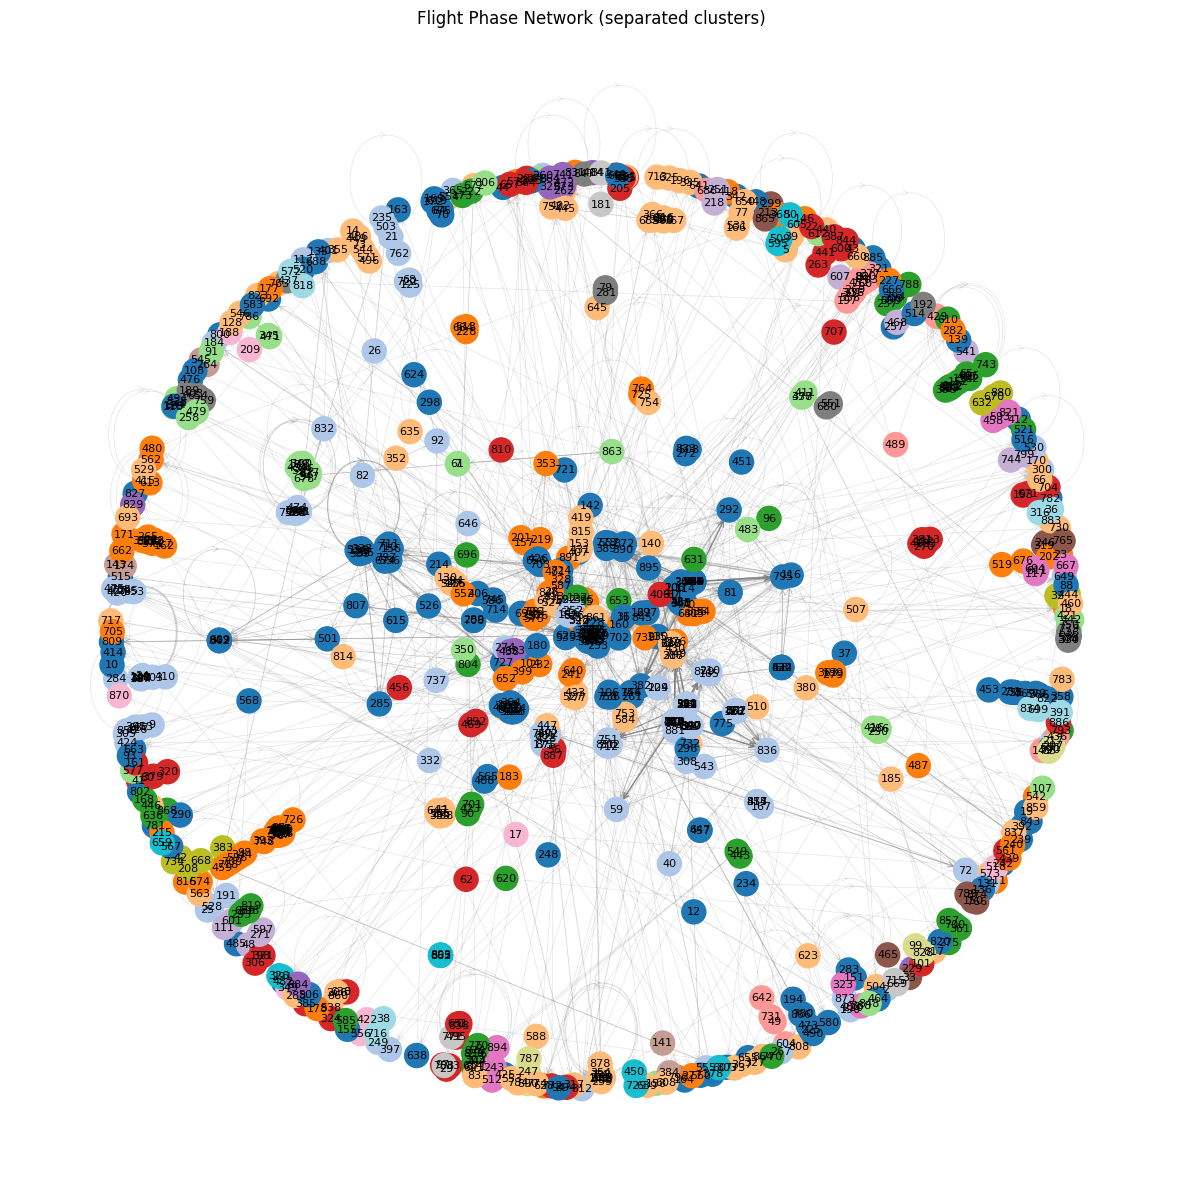

In [53]:
plot_static_graph(G)

In [ ]:
create_interactive_graph(G, filename="html-graphs/motif_network2.html")

## Flight clustering

### Flights as bag of motifs

In this case, we use TF-IDF, the sequentiality within each phase motif is considered, but not the sequentiality of the entire flight.

In [18]:
rows_list = []
significant_motifs = set(df_significant["motif"])

for i, flight in enumerate(flights):
        # flight is a list of ints, e.g., [10, 20, 30, 40]
        if len(flight) < k:
            continue

        # Get significant k-grams from the flight
        ngrams = pd.Series(get_ngrams(flight, k))
        ngrams = ngrams[ngrams.isin(significant_motifs)]
        ngrams = ngrams.apply(lambda x: '_'.join(map(str, x))) # Transform k-grams (x1_x2_xk)

        ngrams = " ".join(ngrams.astype(str))
        
        rows_list.append({'flight_id': sessions[i], 'flight_document': ngrams})

flight_corpus = pd.DataFrame(rows_list)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [20]:
# --- STEP 3: Vectorize (TF-IDF) ---
# This converts the text documents into a numerical matrix
tfidf = TfidfVectorizer(
    lowercase=False,  # Motifs aren't case sensitive
    token_pattern=r"(?u)\b\w+\b" # Default pattern works, but ensuring it captures numbers/underscores
)

X = tfidf.fit_transform(flight_corpus['flight_document'])

# X is now a sparse matrix where Rows = Flights, Columns = Unique Motifs

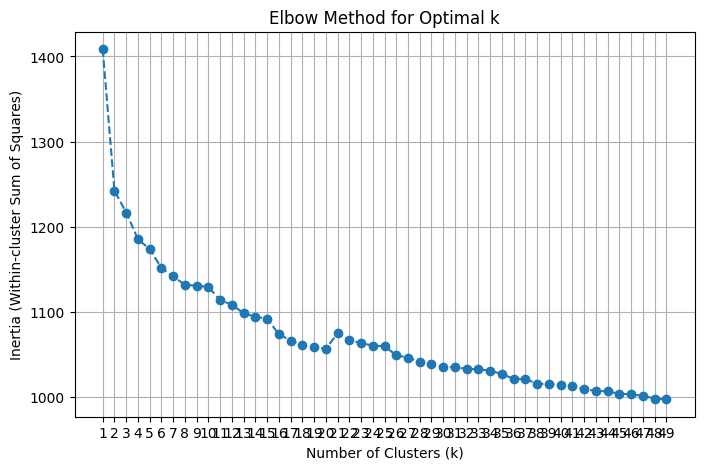

In [27]:
# --- STEP 4: Finding the Optimal K (Elbow Method) ---

inertia = []
k_range = range(1, 50)  # Checking 1 to 10 clusters; adjust based on your data size

for k in k_range:
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_model.fit(X)
    inertia.append(kmeans_model.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [22]:
# --- STEP 5: Final Clustering ---
chosen_k = 6
final_kmeans = KMeans(n_clusters=chosen_k, random_state=42, n_init='auto')
flight_corpus['cluster'] = final_kmeans.fit_predict(X)

# View results
print(f"\nFlights clustered into {chosen_k} groups:")
print(flight_corpus[['flight_id', 'cluster']])


Flights clustered into 6 groups:
      flight_id  cluster
0       3130311        5
1       3130519        3
2       3130827        3
3       3131023        2
4       3131064        3
...         ...      ...
1837    3203713        5
1838    3203715        5
1839    3203716        5
1840    3203719        1
1841    3203720        1

[1842 rows x 2 columns]


In [24]:
def analyse_cluster_uniqueness(cluster_nb):
    for i in range(cluster_nb):
        ids = flight_corpus[flight_corpus["cluster"] == i]["flight_id"]
        aux = flight_info[flight_info["F_SESSION"].isin(set(ids))]

        aircraft_per = len(aux["k_aircraft"].unique())/len(flight_info["k_aircraft"].unique())*100
        operator_per = len(aux["k_operator"].unique())/len(flight_info["k_operator"].unique())*100
        mission_per = len(aux["k_mission"].unique())/len(flight_info["k_mission"].unique())*100

        print(f"Cluster nb {i} had:")
        print(f"\t{aircraft_per:.2f} % of the {len(flight_info['k_aircraft'].unique())} aircrafts")
        print(f"\t{operator_per:.2f} % of the {len(flight_info['k_operator'].unique())} operators")
        print(f"\t{mission_per:.2f} % of the {len(flight_info['k_mission'].unique())} missions\n")

In [26]:
analyse_cluster_uniqueness(len(flight_corpus['cluster'].unique()))

Cluster nb 0 had:
	90.16 % of the 61 aircrafts
	100.00 % of the 15 operators
	75.00 % of the 4 missions

Cluster nb 1 had:
	85.25 % of the 61 aircrafts
	86.67 % of the 15 operators
	75.00 % of the 4 missions

Cluster nb 2 had:
	68.85 % of the 61 aircrafts
	66.67 % of the 15 operators
	50.00 % of the 4 missions

Cluster nb 3 had:
	59.02 % of the 61 aircrafts
	66.67 % of the 15 operators
	75.00 % of the 4 missions

Cluster nb 4 had:
	14.75 % of the 61 aircrafts
	26.67 % of the 15 operators
	50.00 % of the 4 missions

Cluster nb 5 had:
	88.52 % of the 61 aircrafts
	93.33 % of the 15 operators
	100.00 % of the 4 missions



In [75]:
# Create a DataFrame of the cluster centers
feature_names = tfidf.get_feature_names_out()
ordered_centroids = final_kmeans.cluster_centers_.argsort()[:, ::-1]

print("\nTop motifs per cluster:")
for i in range(k):
    print(f"Cluster {i}:")
    # Print the top 3 motifs for this cluster
    for ind in ordered_centroids[i, :3]: 
        print(f" - Motif {feature_names[ind]} (Weight: {final_kmeans.cluster_centers_[i, ind]:.3f})")


Top motifs per cluster:
Cluster 0:
 - Motif 115_115_115_115_115 (Weight: 0.743)
 - Motif 189_190_190_190_190 (Weight: 0.066)
 - Motif 2_6_6_6_6 (Weight: 0.065)
Cluster 1:
 - Motif 2_3_3_3_3 (Weight: 0.154)
 - Motif 3_3_3_3_2 (Weight: 0.148)
 - Motif 5_5_5_5_2 (Weight: 0.138)
Cluster 2:
 - Motif 115_115_115_115_115 (Weight: 0.152)
 - Motif 4_3_3_3_3 (Weight: 0.103)
 - Motif 3_3_3_3_4 (Weight: 0.089)
Cluster 3:
 - Motif 190_190_190_190_191 (Weight: 0.212)
 - Motif 189_190_190_190_190 (Weight: 0.191)
 - Motif 115_115_115_115_115 (Weight: 0.186)
Cluster 4:
 - Motif 7_7_116_7_7 (Weight: 0.556)
 - Motif 116_7_7_7_116 (Weight: 0.177)
 - Motif 7_116_7_116_7 (Weight: 0.173)


### Sequential approach with n-grams

In [ ]:
# --- Setup: Mock Data & Graph ---
# 1. Create a mock directed graph (Your existing graph)
G = nx.DiGraph()
# Edge weights represent "Statistical Significance" (e.g., Z-score or probability)
G.add_edge('1_2', '3_4', weight=0.9)  # Highly significant transition
G.add_edge('3_4', '5_6', weight=0.8)
G.add_edge('1_2', '9_9', weight=0.2)  # Rare/Less significant transition

# 2. Mock Flights (Sequences of motif strings)
data = {
    'flight_id': [1, 2, 3],
    'motif_sequence': [
        ['1_2', '3_4', '5_6'],  # Follows the "standard" high-weight path
        ['1_2', '9_9'],         # Follows the "rare" low-weight path
        ['1_2', '3_4', '5_6']   # Same as flight 1
    ]
}
df = pd.DataFrame(data)

# --- STEP 1: Define the Feature Space (The Graph Edges) ---
# Get a fixed list of edges to serve as our "columns"
# We store them as a list of tuples: [('1_2', '3_4'), ('3_4', '5_6'), ...]
edge_vocabulary = list(G.edges())
edge_to_index = {edge: i for i, edge in enumerate(edge_vocabulary)}
n_features = len(edge_vocabulary)

print(f"Feature Space Size: {n_features} unique significant transitions.")

# --- STEP 2: Vectorize the Flights ---
def vectorize_flight_using_graph(sequence, graph, edge_map, n_feats):
    # Initialize zero vector
    vec = np.zeros(n_feats)
    
    # Iterate through the flight sequence in pairs (bigrams)
    for i in range(len(sequence) - 1):
        u, v = sequence[i], sequence[i+1]
        
        # Check if this transition exists in your significant graph
        if (u, v) in edge_map:
            idx = edge_map[(u, v)]
            
            # KEY LOGIC: 
            # Value = Frequency * Significance Weight
            # We add the graph's weight to the vector. 
            # If a flight takes this path 2 times, it gets 2 * weight.
            significance = graph[u][v]['weight']
            vec[idx] += significance 
            
    return vec

# Apply vectorization to all flights
# Result is a Matrix (Rows=Flights, Cols=Graph Edges)
X_graph = np.vstack(df['motif_sequence'].apply(
    lambda seq: vectorize_flight_using_graph(seq, G, edge_to_index, n_features)
))

# --- STEP 3: Clustering ---
# Now we cluster based on the "Significant Paths" taken
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
df['cluster'] = kmeans.fit_predict(X_graph)

print("\nClustered Flights:")
print(df)

# end

You have moved from a **"Bag of Words" (Unigrams)** approach to a **"Bag of Weighted Transitions" (Bigrams)** approach.

Since you have a graph where edges represent *statistically significant* transitions, you should treat the **edges of your graph** as the features for your clustering, rather than the nodes.

Here is the conceptual shift:

* **Previous Approach:** "Flight A contains Motif 1 and Motif 2."
* **New Approach:** "Flight A traverses the specific path Motif 1  Motif 2, which has a significance weight of ."

This allows you to cluster flights based on **structural behavior** (e.g., "flights that follow the standard landing sequence" vs. "flights that follow a specific go-around sequence").

Here is how to implement this using **NetworkX** and **Scikit-Learn**.

### The Strategy: "Graph-Weighted Bigrams"

1. **Vocabulary Construction:** The "vocabulary" is no longer the list of unique motifs, but the list of **edges** in your graph.
2. **Vectorization:** For each flight, we create a vector of size  (where  is the number of edges in your graph).
3. **Weighting:** If a flight contains the transition , we populate that feature index not just with the count (1), but with the **graph edge weight** (significance). This emphasizes statistically significant transitions over random ones.

### Python Implementation

I will assume your graph `G` is a NetworkX object where edges have a `weight` attribute corresponding to their statistical significance.

### Why this is better than standard N-grams

1. **Noise Reduction:** Standard `CountVectorizer(ngram_range=(2,2))` would create a feature for *every* pair of motifs that ever occurs, creating a massive, sparse matrix full of noise. This approach **only** considers transitions you have already deemed "significant" in your graph.
2. **Significance Weighting:** By multiplying the occurrence count by the edge weight (`vec[idx] += significance`), you force the clustering algorithm to pay more attention to the "important" transitions. A flight that deviates from the graph (traverses edges that don't exist or have low weight) will result in a zero or low-magnitude vector, naturally separating it from "standard" flights.

### Advanced: Using Graph Embeddings (Node2Vec)

If you want to go even deeper, you can use **Node2Vec**.

* **Concept:** Instead of counting edges, you learn a vector for every *Node* in your graph based on its neighbors.
* **Application:** If Motif A and Motif B are structurally similar in your graph (e.g., they both lead to "Landing"), Node2Vec will give them similar vectors.
* **Flight Vector:** A flight becomes the **average** of the vectors of the motifs it visits.

This is useful if you have **different motifs that represent the same flight phase behavior**. The method above (Edge Counting) treats Motif A and Motif B as completely different features. Node2Vec would "understand" they are related.

**Would you like to see the implementation for the Node2Vec approach, or is the Weighted Edge approach sufficient?**